In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
plt.style.use('ggplot') 
import calendar
import quandl
import pickle
from datetime import datetime, timedelta
import re  
import psycopg2
import sys
api_key = '764-Cog1Q3xa6Rns5pmj'
quandl.ApiConfig.api_key = api_key
import sqlalchemy
from sqlalchemy.sql import select, and_, or_, not_, desc, asc
from sqlalchemy import Table, Column, Integer, DateTime, String,Float, ForeignKey
from sqlalchemy.orm import sessionmaker

In [2]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

In [3]:
def connect(user, password, db, host='localhost', port=5432):
    '''Returns a connection and a metadata object'''
    # We connect with the help of the PostgreSQL URL
    url = 'postgresql+psycopg2://{}:{}@{}:{}/{}'
    url = url.format(user, password, host, port, db)

    # The return value of create_engine() is our connection object
    con = sqlalchemy.create_engine(url, client_encoding='utf8')

    # We then bind the connection to MetaData()
    meta = sqlalchemy.MetaData(bind=con)

    return con, meta

CREATE TABLES 

In [4]:
con, meta = connect('postgres', '', 'robotdb')
    
tickers = Table('Ticker', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('price', Float),
    Column('volume', Float),
    Column('screen', String, primary_key = True)    
)

macd = Table('Macd', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('ema12', Float),
    Column('ema_26', Float),
    Column('macd_line', Float),
    Column('signal_line', Float),
    Column('histogram', Float),
    Column('screen', Integer, primary_key=True)
)

boillinger = Table('Boillinger', meta,
                       Column('date', DateTime, primary_key=True),
                       Column('coin', String, primary_key=True),
                       Column('upper_band', Float),
                       Column('lower_band', Float),
                       Column('sma20', Float),
                       Column('height', Float),
                       Column('screen', Integer, primary_key=True)
                       )

ema = Table('Ema', meta,
                Column('date', DateTime, primary_key=True),
                Column('coin', String, primary_key=True),
                Column('ema5', Float),
                Column('ema20', Float),
                Column('ema5_theta', Float),
                Column('ema20_theta', Float),
                Column('screen', Integer, primary_key=True)
                )

long_positions = Table('Long', meta,
                       Column('id_position', Integer, primary_key=True),
                       Column('coin', String, primary_key=True),
                       Column('strategy', String),
                       Column('size_position', Float),
                       Column('date_ask', DateTime),
                       Column('ask', Float),
                       Column('date_settlement', DateTime),
                       Column('settlement', Float),
                       Column('take_profit', Float),
                       Column('stop_loss', Float),
                       Column('exit_date', DateTime),
                       Column('exit_price', Float),
                       Column('log_return', Float),
                       Column('source', String),
                       Column('status', String)
                       )


mkt_trend = Table('Market_trend', meta,
                  Column('coin', String, primary_key=True),
                  Column('date', DateTime, primary_key=True),
                  Column('screen', Integer, primary_key=True),
                  Column('dif_current', Float),
                  Column('dif_base', Float),
                  Column('d_dif', Float),
                  Column('theta_current', Float),
                  Column('theta_base', Float),
                  Column('d_theta', Float),
                  Column('max_growth', Float),
                  Column('vote', Integer)
                  )


rsi = Table('Rsi', meta,
    Column('date', DateTime, primary_key = True),
    Column('coin', String, primary_key = True),
    Column('rsi', Float),
    Column('screen', Integer, primary_key=True)
)

balances = Table('Balance', meta,
                 Column('date', DateTime, primary_key=True),
                 Column('coin', String, primary_key=True),
                 Column('size_position', Float)
                 )


years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

In [5]:
def get_macds(coin = None, date = '2019-12-31', screen = 1):
    if coin:
        s = select([macd])\
            .where(and_(macd.c.coin == coin, macd.c.date <= date, macd.c.screen==screen))\
            .order_by(desc(macd.c.date))
    else:
         s = select([macd])\
            .where(and_(macd.c.date <= date, macd.c.screen==screen))\
            .order_by(desc(macd.c.date))
            
    rows = con.execute(s)
    macd_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not macd_df.empty:
        macd_df.columns = rows.keys()
    return macd_df

def get_tickers(coin = None, date = '2019-12-31', screen = 1):
    if coin:
        s = select([tickers])\
            .where(and_(tickers.c.coin == coin, tickers.c.date <= date, tickers.c.screen == screen))\
            .order_by(
            desc(tickers.c.date))
    else:
        s = select([tickers])\
            .where(and_(tickers.c.date <= date, tickers.c.screen == screen))\
            .order_by(
            desc(tickers.c.date))
    rows = con.execute(s)
    tickers_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not tickers_df.empty:
        tickers_df.columns = rows.keys()
    return tickers_df

def get_emas(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([ema])\
            .where(and_(ema.c.coin == coin, ema.c.date <= date, ema.c.screen == screen))\
            .order_by(ema.c.date.desc())
    else:
        s = select([ema])\
            .where(and_(ema.c.date <= date, ema.c.screen == screen))\
            .order_by(ema.c.date.desc())
    rows = con.execute(s)
    ema_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not ema_df.empty:
        ema_df.columns = rows.keys()
    return ema_df

def get_mkt_trend(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([mkt_trend]).\
            where(and_(mkt_trend.c.coin == coin, mkt_trend.c.date <= date, mkt_trend.c.screen == screen)).\
            order_by(desc(mkt_trend.c.date))
    else:
        s = select([mkt_trend]).\
            where(and_(mkt_trend.c.date <= date, mkt_trend.c.screen == screen)).\
            order_by(desc(mkt_trend.c.date))
    rows = con.execute(s)
    mkt_trend_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    mkt_trend_df.columns = rows.keys()
    return mkt_trend_df

def get_rsis(coin=None, date='2019-12-31', screen=1):
    if coin:
        s = select([rsi]) \
            .where(and_(rsi.c.coin == coin,
                        rsi.c.date <= date,
                       rsi.c.screen == screen))\
            .order_by(desc(rsi.c.date))
    else:
        s = select([rsi]) \
            .where(and_(rsi.c.date <= date,
                        rsi.c.screen == screen
                       ))\
            .order_by(desc(rsi.c.date))
    rows = con.execute(s)
    rsi_df = pd.DataFrame(rows.fetchall()).iloc[::-1]
    if not rsi_df.empty:
        rsi_df.columns = rows.keys()
    return rsi_df

In [6]:
def manipulate_mkt_data():
    mkt_trend_df = get_mkt_trend()
    tickers_df_two = get_tickers()
    macds_df = get_macds()
    tickers_df = pd.merge(tickers_df_two, macds_df, how='inner', left_on=['date', 'coin'], right_on=['date', 'coin'])
    tickers_df['ema_dif'] = np.log(tickers_df['price']/tickers_df['ema12'])
    df = pd.merge(mkt_trend_df, tickers_df, how='inner', left_on=['date', 'coin'], right_on=['date', 'coin'])
    rsis_df = get_rsis()
    df = pd.merge(df, rsis_df, how='inner', left_on=['date', 'coin'], right_on=['date', 'coin'])
    return df
    
df = manipulate_mkt_data()

In [7]:
df.loc[df['max_growth'] >= 0.1, 'growth_sign'] = 1
df.loc[df['max_growth'] < 0.1, 'growth_sign'] = 0
df['rsi'] = df['rsi']/100

In [8]:
full_data_set = df[['coin', 'date', 'dif_base', 'dif_current', 'd_dif', 'theta_base', 'theta_current','d_theta', 'rsi','ema_dif', 'max_growth', 'growth_sign']]

dates_ = full_data_set[['date']]
shifted_parms = full_data_set[['coin', 'dif_current', 'theta_current']].shift(2)
shifted_parms['date'] = dates_
full_data_set = pd.merge(full_data_set, shifted_parms, how='inner', left_on=['date', 'coin'], right_on=['date', 'coin'])
full_data_set.head()
full_data_set['dif_current'] = full_data_set['dif_current_x']
full_data_set['theta_current'] = full_data_set['theta_current_x']
full_data_set['dif_base_p'] = full_data_set['dif_current_y']
full_data_set['theta_base_p'] = full_data_set['theta_current_y']

In [9]:
df_model = full_data_set.sort_values(['date'])

In [10]:
def get_strength_index():
    tickers_df_two = get_tickers()
    for c in tickers_df_two.coin.unique():
        tickers_df_two_c = tickers_df_two[tickers_df_two['coin'] == c]
        print(c)
        # 6 * 4h = 24h
        delta_t = 1
        si_np = [np.nan]
        for index in range(len(tickers_df_two_c)):
            base_price = tickers_df_two_c.iloc[index].price
            if index >= (len(tickers_df_two_c)-delta_t):
                break
            current_price = tickers_df_two_c.iloc[index+1].price
            volume = tickers_df_two_c.iloc[index+1].volume
            si = (current_price - base_price) * volume
            si_np.append(si)
        tickers_df_two_c['strength'] = si_np
    return tickers_df_two_c.dropna()

df_model = pd.merge(df_model, get_strength_index(), how='inner',
                    left_on=['date', 'coin'], right_on=['date', 'coin'])
df_model['ema_s'] = df_model.drop(['date', 'coin'], axis=1).strength.\
                    ewm(span=2, min_periods=2, adjust=True, ignore_na=False).mean()
    

USDT_BTC


In [11]:
df_model = df_model[['date', 'dif_base', 'dif_current', 'd_dif', 'theta_base', 'theta_current', 'rsi',
                     'strength','d_theta', 'ema_dif', 'dif_base_p', 'theta_base_p', 'max_growth', 'growth_sign']].dropna()
df_model.head()

,date,dif_base,dif_current,d_dif,theta_base,theta_current,rsi,strength,d_theta,ema_dif,dif_base_p,theta_base_p,max_growth,growth_sign
0,2017-05-27 19:15:00,-0.064036,-0.067736,0.057782,1.331456,1.168655,0.390028,-8.643714e+08,-0.122273,-0.038297,-0.065930,-1.145981,0.085196,0.0
1,2017-05-27 23:15:00,-0.067736,-0.063983,-0.055416,1.168655,-1.096829,0.434543,7.145888e+08,-1.938540,0.013925,-0.064036,1.331456,0.065394,0.0
2,2017-05-28 03:15:00,-0.063983,-0.060871,-0.048632,-1.096829,1.130954,0.390022,6.387661e+07,-2.031112,0.018640,-0.067736,1.168655,0.061871,0.0
3,2017-05-28 07:15:00,-0.060871,-0.052909,-0.130798,1.130954,0.149442,0.385072,9.167132e+08,-0.867862,0.063735,-0.063983,-1.096829,0.003772,0.0
4,2017-05-28 11:15:00,-0.052909,-0.046516,-0.120826,0.149442,1.166785,0.416881,-3.505537e+08,6.807588,0.038641,-0.060871,1.130954,0.000000,0.0


In [12]:
x_features = ['dif_base_p', 'dif_base', 'dif_current',
              'theta_base_p', 'theta_base','theta_current',
              'rsi', 'ema_dif']
y_features = ['growth_sign']

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV

models_result = []

#Random Forest With Unbalanced Dataset: Not Good

Random Forest with Balanced Dataset (SMOTE)

In [14]:
model = 'RF SMOTE'
X = df_model[x_features]
y = df_model[y_features].growth_sign.values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
oversampler = SMOTE(random_state=42)

X_train_os,Y_train_os=oversampler.fit_sample(X_train,Y_train)
rf_os = RandomForestClassifier(random_state=42)
rf_os.fit(X_train_os,Y_train_os)
Y_predict = rf_os.predict(X_test)

In [16]:
print(confusion_matrix(Y_test,Y_predict))
print(classification_report(Y_test,Y_predict))

[[336  11]
 [  6   1]]
             precision    recall  f1-score   support

        0.0       0.98      0.97      0.98       347
        1.0       0.08      0.14      0.11         7

avg / total       0.96      0.95      0.96       354



In [17]:
FP, TP, thresholds = roc_curve(Y_test,Y_predict)
roc_auc = auc(FP, TP)
print (roc_auc)
models_result.append({"model": model,"roc_auc": roc_auc})

0.555578427336


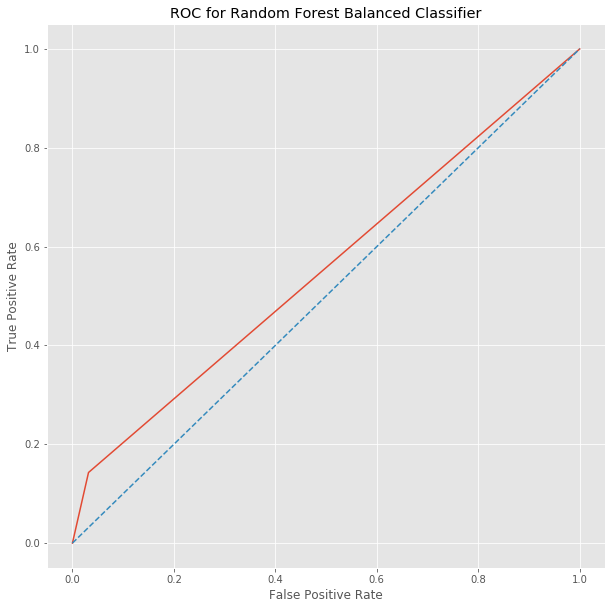

In [18]:
plt.plot(FP, TP, label='AUC = %0.2f'% roc_auc)
plt.title('ROC for Random Forest Balanced Classifier')
plt.plot([0,1],[0,1],'--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Random Forest Classifier SMOTE, With GridSearch

In [19]:
model = 'RF SMOTE GS'
param_grid = {'max_depth': np.arange(1, 12), 'min_samples_leaf':np.arange(1, 12),}

X = df_model[x_features]
y = df_model[y_features].growth_sign.values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
oversampler = SMOTE(random_state=42)
X_train_os, Y_train_os = oversampler.fit_sample(X_train,Y_train)

rf_os = RandomForestClassifier(random_state=42)
rf_os_cv = GridSearchCV(rf_os, param_grid, cv=5, scoring='roc_auc')
rf_os_cv.fit(X_train_os, Y_train_os)

print(rf_os_cv.best_params_)
print(rf_os_cv.best_score_)

{'max_depth': 11, 'min_samples_leaf': 1}
0.994371065106


In [20]:
Y_predict = rf_os_cv.predict(X_test)

In [21]:
print(confusion_matrix(Y_test,Y_predict))
print(classification_report(Y_test,Y_predict))

[[330  17]
 [  6   1]]
             precision    recall  f1-score   support

        0.0       0.98      0.95      0.97       347
        1.0       0.06      0.14      0.08         7

avg / total       0.96      0.94      0.95       354



In [22]:
FP, TP, thresholds = roc_curve(Y_test,Y_predict)
roc_auc = auc(FP, TP)
print (roc_auc)
models_result.append({"model": model,"roc_auc": roc_auc})

0.546932894195


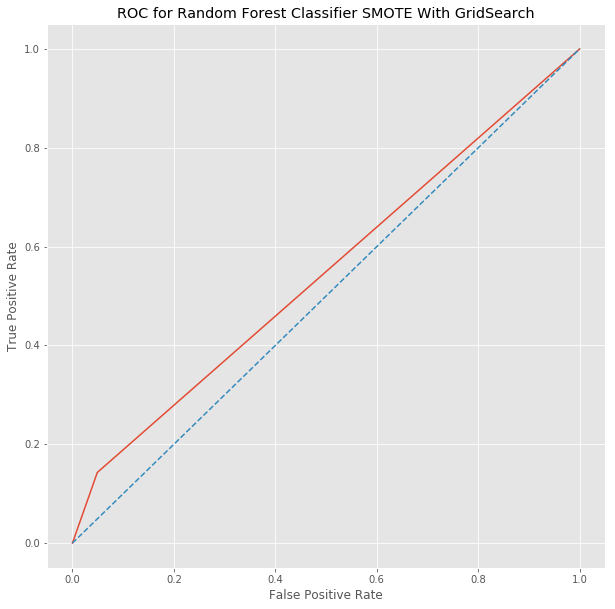

In [23]:
plt.plot(FP, TP, label='AUC = %0.2f'% roc_auc)
plt.title('ROC for Random Forest Classifier SMOTE With GridSearch')
plt.plot([0,1],[0,1],'--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

KNN Classifier With Balanced Dataset (SMOTE)

In [24]:
model = 'KNN SMOTE'
X = df_model[x_features]
y = df_model[y_features].growth_sign.values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
oversampler = SMOTE(random_state=42)
X_train_os, Y_train_os = oversampler.fit_sample(X_train,Y_train)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_os, Y_train_os)
Y_predict = knn.predict(X_test)

In [25]:
print(confusion_matrix(Y_test,Y_predict))
print(classification_report(Y_test,Y_predict))

[[331  16]
 [  5   2]]
             precision    recall  f1-score   support

        0.0       0.99      0.95      0.97       347
        1.0       0.11      0.29      0.16         7

avg / total       0.97      0.94      0.95       354



In [26]:
FP, TP, thresholds = roc_curve(Y_test,Y_predict)
roc_auc = auc(FP, TP)
print (roc_auc)
models_result.append({"model": model,"roc_auc": roc_auc})

0.619802387814


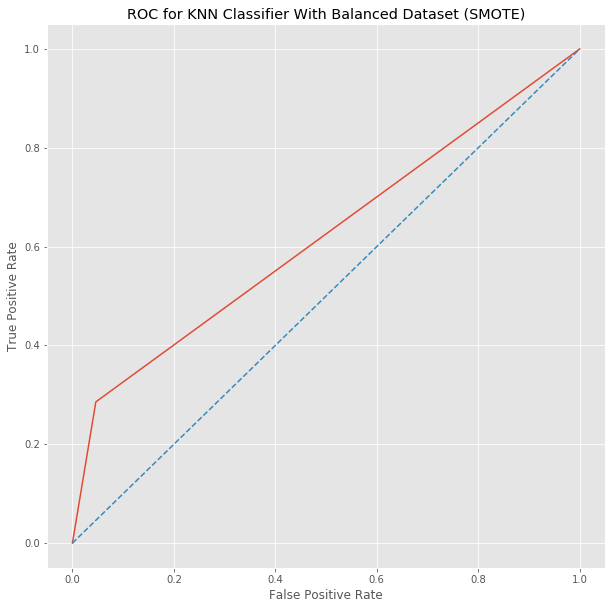

In [27]:
plt.plot(FP, TP, label='AUC = %0.2f'% roc_auc)
plt.title('ROC for KNN Classifier With Balanced Dataset (SMOTE)')
plt.plot([0,1],[0,1],'--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

KNN Classifier With Balanced Dataset and GridSearchCV

In [28]:
model = 'KNN SMOTE GS'
param_grid = {'n_neighbors': np.arange(1, 50)}

X = df_model[x_features]
y = df_model[y_features].growth_sign.values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

oversampler = SMOTE(random_state=42)
X_train_os, Y_train_os = oversampler.fit_sample(X_train,Y_train)

knn = KNeighborsClassifier(algorithm = 'brute')
knn_cv = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc')
knn_cv.fit(X_train_os, Y_train_os)

print(knn_cv.best_params_)
print(knn_cv.best_score_)

{'n_neighbors': 6}
0.983944599208


In [29]:
Y_predict = knn_cv.predict(X_test)

In [30]:
FP, TP, thresholds = roc_curve(Y_test,Y_predict)
roc_auc = auc(FP, TP)
print (roc_auc)
models_result.append({"model": model,"roc_auc": roc_auc})

0.539728283244


In [31]:
print(confusion_matrix(Y_test,Y_predict))
print(classification_report(Y_test,Y_predict))

[[325  22]
 [  6   1]]
             precision    recall  f1-score   support

        0.0       0.98      0.94      0.96       347
        1.0       0.04      0.14      0.07         7

avg / total       0.96      0.92      0.94       354



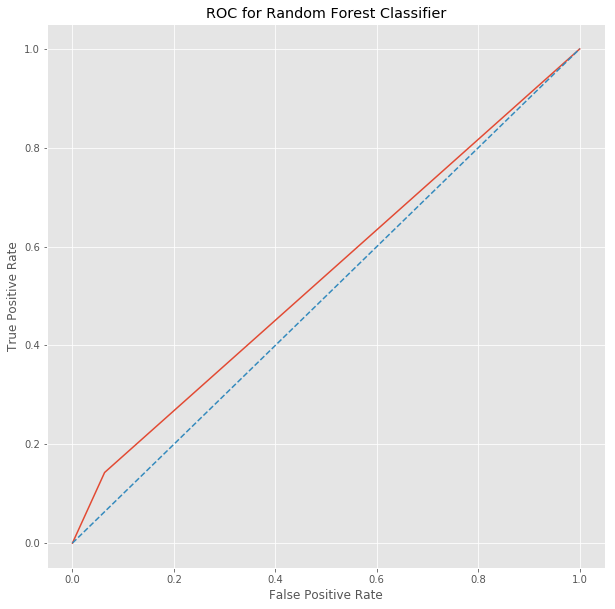

In [32]:
plt.plot(FP, TP, label='AUC = %0.2f'% roc_auc)
plt.title('ROC for Random Forest Classifier')
plt.plot([0,1],[0,1],'--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
from sklearn import svm, grid_search

model = 'SVC SMOTE GS'

X = df_model[x_features]
y = df_model[y_features].growth_sign.values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]
param_grid = {'C': Cs, 'gamma' : gammas}

oversampler = SMOTE(random_state=42)
X_train_os, Y_train_os = oversampler.fit_sample(X_train,Y_train)

svm_greed = GridSearchCV(svm.SVC(), param_grid, cv=5)
svm_greed.fit(X_train_os, Y_train_os)
svm_greed.best_params_

In [ ]:
Y_predict = svm_greed.predict(X_test)

In [ ]:
cm = confusion_matrix(Y_test,Y_predict)
print(cm)
print(classification_report(Y_test,Y_predict))

In [ ]:
FP, TP, thresholds = roc_curve(Y_test,Y_predict)
roc_auc = auc(FP, TP)
print (roc_auc)
models_result.append({"model": model,"roc_auc": roc_auc})

In [ ]:
plt.plot(FP, TP, label='AUC = %0.2f'% roc_auc)
plt.title('ROC for Random Forest Classifier SMOTE With GridSearch')
plt.plot([0,1],[0,1],'--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
from xgboost import XGBClassifier

model = 'XGBoost GS'

X = df_model[x_features]
y = df_model[y_features].growth_sign.values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)


param_grid = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2),
'gamma': [i/10.0 for i in range(0,5)]
}

xgb_grid = GridSearchCV(XGBClassifier(scale_pos_weight=1, seed=42,  subsample=0.8,
                                      scoring='roc_auc',objective='binary:logistic',
                                     n_jobs=4), param_grid, cv=5)
xgb_grid.fit(X_train, Y_train)
xgb_grid.best_params_

In [ ]:
Y_predict = xgb_grid.predict(X_test)

In [ ]:
FP, TP, thresholds = roc_curve(Y_test,Y_predict)
roc_auc = auc(FP, TP)
print (roc_auc)
models_result.append({"model": model,"roc_auc": roc_auc})

In [ ]:
plt.plot(FP, TP, label='AUC = %0.2f'% roc_auc)
plt.title('ROC for XGBoost Classifier SMOTE With GridSearch')
plt.plot([0,1],[0,1],'--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
models_result